# **Measuring how Frozen & Imbalanced the Job Market is** 
## (01-03-2006 to 04-01-2025)


# DERIVED FEATURES

### 📊 **Derived Metrics to Compare Supply vs. Demand**

---

| Feature Name                 | Equation                                               | Interpretation                        | Why It Matters                                                       | Supply or Demand |
| ---------------------------- | ------------------------------------------------------ | ------------------------------------- | -------------------------------------------------------------------- | ---------------- |
| OpeningsPerUnemployed        | Job\_Openings\_Rate / Unemployment\_Level              | Openings per unemployed person        | Signals labor tightness or slack                                     | Demand           |
| OpeningsPerHire              | Job\_Openings\_Rate / Hires\_Rate                      | Openings per hire                     | High values imply hiring friction or mismatch                        | Demand           |
| HiresPerUnemployed           | Hires\_Rate / Unemployment\_Level                      | Hires per unemployed person           | Indicates efficiency of unemployed absorption                        | Demand           |
| QuitsPerUnemployed           | Quits\_Rate / Unemployment\_Level                      | Quits per unemployed person           | Reflects worker confidence in finding new jobs                       | Supply           |
| LayoffsPerOpening            | Layoffs\_and\_Discharges / Job\_Openings\_Rate         | Layoffs per opening                   | High values imply instability or contradictory signals               | Supply           |
| QuitsPerLayoffs              | Quits\_Rate / Layoffs\_and\_Discharges                 | Voluntary vs involuntary separations  | Indicates whether workers are confident or being forced out          | Supply           |
| NILFWJNPerPop                | Not\_In\_Labor\_Force\_WantAJobNow / Total\_Population | Hidden unemployed in total population | Captures discouraged workers not counted in official stats           | Supply           |
| MarginallyAttachedPerNILF    | Marginally\_Attached\_Workers / Not\_in\_Labor\_Force  | Share of NILF willing to work         | Signals potential re-entry into workforce                            | Supply           |
| CPIYOY                       | CPI.pct\_change(12) \* 100                             | Year-over-year inflation              | Tracks price pressure impacting wages and hiring                     | Demand           |
| TempHelpEmploymentYoY        | Temp\_Help\_Services.pct\_change(12) \* 100            | YoY growth of temp jobs               | Leading indicator of labor demand swings                             | Demand           |
| AvgWeeklyEarningYoY          | Avg\_Weekly\_Earning.pct\_change(12) \* 100            | Nominal earnings growth               | High growth indicates wage pressure or labor bargaining power        | Demand           |
| RealAvgWeeklyEarningsYoY     | AvgWeeklyEarningYoY - CPIYOY                           | Real wage growth (inflation-adjusted) | Indicates actual purchasing power of workers                         | Supply           |
| U6\_U3\_Spread               | U6\_Unemployment\_Rate - U3\_Unemployment\_Rate        | Underemployment spread                | Captures hidden slack beyond official unemployment                   | Supply           |
| HourlyEarningsEstimate       | Average\_Weekly\_Earnings / Average\_Weekly\_Hours     | Implied average hourly compensation   | Normalizes earnings for hours worked; purer measure of wage pressure | Demand           |
| ApplicantsPerJobProxy | Unemployment\_Level / Job\_Openings\_Rate              | Job seekers per opening (congestion)  | Higher values = more labor supply pressure per available job         | Supply           |

---


In [302]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames

Layoffs_df = pd.read_csv('JOLTS/Layoffs.csv')
Total_Seperations_df = pd.read_csv('JOLTS/Total_Seperations.csv')
Temp_Help_Employment_df = pd.read_csv('Demand_vs_Supply/Temporary_Help_Services_Employment.csv')
Avg_Weekly_Earnings_df = pd.read_csv('Demand_vs_Supply/Average_Weekly_Earnings.csv')
Avg_Weekly_Hours_df = pd.read_csv('Demand_vs_Supply/Average_Weekly_Hours.csv')
Median_Hourly_Wage_Growth_df = pd.read_csv('Demand_vs_Supply/Median_Hourly_Wage_Growth.csv')
Total_Pop_df = pd.read_csv('JOLTS/Total_Population.csv')
Not_in_Labor_Force_df = pd.read_csv('Demand_vs_Supply/Not_in_Labor_Force.csv')
U6_Unempoyment_df = pd.read_csv('Demand_vs_Supply/U6_Unemployment_Rate.csv')
U3_Unempoyment_df = pd.read_csv('Demand_vs_Supply/U3_Unemployment_Rate.csv')
U2_Unempoyment_df = pd.read_csv('Demand_vs_Supply/U2_Unemployment_Rate.csv')
Unemployment_Level_df = pd.read_csv('Demand_vs_Supply/Unemployment_Level.csv')
Prime_Employment_to_Pop_Ratio_df = pd.read_csv('Demand_vs_Supply/Prime_Employment_to_Population_Ratio.csv')
CPI_df = pd.read_csv('Demand_vs_Supply/CPI.csv')
Median_Weeks_Unemployed_df= pd.read_csv('Demand_vs_Supply/Median_Weeks_Unemployed.csv')
Initial_Jobless_Claims_df = pd.read_csv('Demand_vs_Supply/Initial_Jobless_Claims.csv')
Job_Openings_Rate_df = pd.read_csv('JOLTS/Job_Openings_Rate.csv')
Quits_Rate_df = pd.read_csv('JOLTS/Quits_Rate.csv')
Unemployment_Level_df = pd.read_csv('Demand_vs_Supply/Unemployment_Level.csv')
Hires_Rate_df = pd.read_csv('JOLTS/Hires_Rate.csv')
NILFWJN_df = pd.read_csv('Demand_vs_Supply/NILFWJN.csv')
Not_in_Labor_Force_df = pd.read_csv('Demand_vs_Supply/Not_in_Labor_Force.csv')
Marginally_Attached_df = pd.read_csv('Demand_vs_Supply/Marginally_Attached.csv')
Involuntary_Part_Time_df = pd.read_csv('Demand_vs_Supply/Involuntary_Part_Time.csv')



# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
Layoffs_df.to_sql('Layoff', conn, index=False, if_exists='replace')
Total_Seperations_df.to_sql('Seperation', conn, index=False, if_exists='replace')
Temp_Help_Employment_df.to_sql('Temp_Help', conn, index=False, if_exists='replace')
Avg_Weekly_Earnings_df.to_sql('Weekly_Earning', conn, index=False, if_exists='replace')
Avg_Weekly_Hours_df.to_sql('Weekly_Hours', conn, index=False, if_exists='replace')
Median_Hourly_Wage_Growth_df.to_sql('Median_Wage_Growth', conn, index=False, if_exists='replace')
Total_Pop_df.to_sql('Population', conn, index=False, if_exists='replace')
Not_in_Labor_Force_df.to_sql('NILF', conn, index=False, if_exists='replace')
U6_Unempoyment_df.to_sql('U6', conn, index=False, if_exists='replace')
U3_Unempoyment_df.to_sql('U3', conn, index=False, if_exists='replace')
U2_Unempoyment_df.to_sql('U2', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployment_Level', conn, index=False, if_exists='replace')
Prime_Employment_to_Pop_Ratio_df.to_sql('Prime_ETPR', conn, index=False, if_exists='replace')
CPI_df.to_sql('CPI', conn, index=False, if_exists='replace')
Median_Weeks_Unemployed_df.to_sql('Median_Weeks_Unemployed', conn, index=False, if_exists='replace')
Initial_Jobless_Claims_df.to_sql('Initial_Claims', conn, index=False, if_exists='replace')
Job_Openings_Rate_df.to_sql('Job_Openings', conn, index=False, if_exists='replace')
Quits_Rate_df.to_sql('Quits', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployment', conn, index=False, if_exists='replace')
Hires_Rate_df.to_sql('Hires', conn, index=False, if_exists='replace')
NILFWJN_df.to_sql('NILFWJN', conn, index=False, if_exists='replace')
Not_in_Labor_Force_df.to_sql('Not_in_Labor_Force', conn, index=False, if_exists='replace')
Marginally_Attached_df.to_sql('Marginally_Attached', conn, index=False, if_exists='replace')
Involuntary_Part_Time_df.to_sql('Involuntary_Part_Time', conn, index=False, if_exists='replace')





# SQL query to merge all tables on 'Player'
sql_query = """
SELECT *
FROM Weekly_Hours
JOIN Layoff ON Weekly_Hours.observation_date = Layoff.observation_date
JOIN Job_Openings ON Weekly_Hours.observation_date = Job_Openings.observation_date
JOIN Quits ON Weekly_Hours.observation_date = Quits.observation_date
JOIN Unemployment ON Weekly_Hours.observation_date = Unemployment.observation_date
JOIN Hires ON Weekly_Hours.observation_date = Hires.observation_date
JOIN Seperation ON Weekly_Hours.observation_date = Seperation.observation_date
JOIN Temp_Help ON Weekly_Hours.observation_date = Temp_Help.observation_date
JOIN Weekly_Earning ON Weekly_Hours.observation_date = Weekly_Earning.observation_date
JOIN Median_Wage_Growth ON Weekly_Hours.observation_date = Median_Wage_Growth.observation_date
JOIN Population ON Weekly_Hours.observation_date = Population.observation_date
JOIN NILF ON Weekly_Hours.observation_date = NILF.observation_date
JOIN U6 ON Weekly_Hours.observation_date = U6.observation_date
JOIN U3 ON Weekly_Hours.observation_date = U3.observation_date
JOIN U2 ON Weekly_Hours.observation_date = U2.observation_date
JOIN Prime_ETPR ON Weekly_Hours.observation_date = Prime_ETPR.observation_date
JOIN CPI ON Weekly_Hours.observation_date = CPI.observation_date
JOIN Median_Weeks_Unemployed ON Weekly_Hours.observation_date = Median_Weeks_Unemployed.observation_date
JOIN Initial_Claims ON Weekly_Hours.observation_date = Initial_Claims.observation_date
JOIN NILFWJN ON Weekly_Hours.observation_date = NILFWJN.observation_date
JOIN Not_in_Labor_Force ON Weekly_Hours.observation_date = Not_in_Labor_Force.observation_date
JOIN Marginally_Attached ON Weekly_Hours.observation_date = Marginally_Attached.observation_date
JOIN Involuntary_Part_Time ON Weekly_Hours.observation_date = Involuntary_Part_Time.observation_date

"""


# Execute the query and load results into a DataFrame
Supply_Demand_Indicators_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user

Supply_Demand_Indicators_df

,observation_date,Avg_Weekly_Hours,observation_date,Layoffs_and_Discharges,observation_date,Job_Openings_Rate,observation_date,Quits_Rate,observation_date,Unemployment_Level,...,observation_date,InitialJoblessClaims,observation_date,Not_In_Labor_Force_WantAJobNow,observation_date,Not_in_Labor_Force,observation_date,Marginally_Attached_Workers,observation_date,Involuntary_Part_Time
0,2006-03-01,34.2,2006-03-01,1888,2006-03-01,4732,2006-03-01,2956,2006-03-01,7072,...,2006-03-01,301750,2006-03-01,4918,2006-03-01,77161,2006-03-01,451,2006-03-01,3972
1,2006-04-01,34.3,2006-04-01,1853,2006-04-01,4790,2006-04-01,2778,2006-04-01,7120,...,2006-04-01,303600,2006-04-01,4719,2006-04-01,77318,2006-04-01,381,2006-04-01,3900
2,2006-05-01,34.3,2006-05-01,1991,2006-05-01,4463,2006-05-01,3002,2006-05-01,6980,...,2006-05-01,332750,2006-05-01,4635,2006-05-01,77359,2006-05-01,323,2006-05-01,4111
3,2006-06-01,34.4,2006-06-01,1817,2006-06-01,4614,2006-06-01,3042,2006-06-01,7001,...,2006-06-01,305500,2006-06-01,4726,2006-06-01,77317,2006-06-01,481,2006-06-01,4318
4,2006-07-01,34.3,2006-07-01,1860,2006-07-01,4394,2006-07-01,3047,2006-07-01,7175,...,2006-07-01,318800,2006-07-01,4862,2006-07-01,77535,2006-07-01,428,2006-07-01,4303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2024-12-01,34.2,2024-12-01,1669,2024-12-01,7508,2024-12-01,3095,2024-12-01,6886,...,2024-12-01,222250,2024-12-01,5505,2024-12-01,101091,2024-12-01,491,2024-12-01,4358
226,2025-01-01,34.1,2025-01-01,1674,2025-01-01,7762,2025-01-01,3256,2025-01-01,6849,...,2025-01-01,213500,2025-01-01,5479,2025-01-01,101941,2025-01-01,630,2025-01-01,4477
227,2025-02-01,34.2,2025-02-01,1780,2025-02-01,7480,2025-02-01,3250,2025-02-01,7052,...,2025-02-01,226000,2025-02-01,5893,2025-02-01,102487,2025-02-01,463,2025-02-01,4937
228,2025-03-01,34.3,2025-03-01,1590,2025-03-01,7200,2025-03-01,3344,2025-03-01,7083,...,2025-03-01,223200,2025-03-01,5915,2025-03-01,102431,2025-03-01,458,2025-03-01,4780


In [303]:
Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.loc[:, ~Supply_Demand_Indicators_df.columns.duplicated()]

# Supply vs Demand Indicators
Supply_Demand_Indicators_df['OpeningsPerUnemployed']= Supply_Demand_Indicators_df['Job_Openings_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
Supply_Demand_Indicators_df['OpeningsPerHire']= Supply_Demand_Indicators_df['Job_Openings_Rate']/Supply_Demand_Indicators_df['Hires_Rate']
Supply_Demand_Indicators_df['HiresPerUnemployed']= Supply_Demand_Indicators_df['Hires_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
Supply_Demand_Indicators_df['QuitsPerUnemployed']= Supply_Demand_Indicators_df['Quits_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
Supply_Demand_Indicators_df['LayoffsPerOpening']= Supply_Demand_Indicators_df['Layoffs_and_Discharges']/Supply_Demand_Indicators_df['Job_Openings_Rate']
Supply_Demand_Indicators_df['QuitsPerLayoffs']= Supply_Demand_Indicators_df['Quits_Rate']/Supply_Demand_Indicators_df['Layoffs_and_Discharges']
Supply_Demand_Indicators_df['NILFWJNPerPop']= Supply_Demand_Indicators_df['Not_In_Labor_Force_WantAJobNow']/Supply_Demand_Indicators_df['Total_Population']
Supply_Demand_Indicators_df['MarginallyAttachedPerNILF']= Supply_Demand_Indicators_df['Marginally_Attached_Workers']/Supply_Demand_Indicators_df['Not_in_Labor_Force']
Supply_Demand_Indicators_df['ApplicantsPerJobProxy']= Supply_Demand_Indicators_df['Unemployment_Level']/Supply_Demand_Indicators_df['Job_Openings_Rate']


# Other Market Indicators
Supply_Demand_Indicators_df['CPIYOY']= Supply_Demand_Indicators_df['CPI'].pct_change(periods=12) * 100
Supply_Demand_Indicators_df['TempHelpEmploymentYoY']= Supply_Demand_Indicators_df['Temp_Help_Services'].pct_change(periods=12) * 100
Supply_Demand_Indicators_df['AvgWeeklyEarningYoY']= Supply_Demand_Indicators_df['Avg_Weekly_Earning'].pct_change(periods=12) * 100
Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY']= Supply_Demand_Indicators_df['AvgWeeklyEarningYoY'] - Supply_Demand_Indicators_df['CPIYOY']
Supply_Demand_Indicators_df['HourlyEarningEstimate'] = Supply_Demand_Indicators_df['Avg_Weekly_Earning'] - Supply_Demand_Indicators_df['Avg_Weekly_Hours']
Supply_Demand_Indicators_df['U6_U3_Spread'] = (Supply_Demand_Indicators_df['U6_Unemployment_Rate'] - Supply_Demand_Indicators_df['U3_Unemployment_Rate'])

In [304]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.loc[:, ~Supply_Demand_Indicators_df.columns.duplicated()]
# Standardize (z-score) each feature
Supply_Demand_Indicators_df['Unemployed_z'] = zscore(Supply_Demand_Indicators_df['Unemployment_Level'], nan_policy='omit')
Supply_Demand_Indicators_df['NILFWJN_z'] = zscore(Supply_Demand_Indicators_df['Not_In_Labor_Force_WantAJobNow'], nan_policy='omit')
Supply_Demand_Indicators_df['Marginally_Attached_z'] = zscore(Supply_Demand_Indicators_df['Marginally_Attached_Workers'], nan_policy='omit')
Supply_Demand_Indicators_df['Involuntary_Part_Time_Rate_z'] = zscore(Supply_Demand_Indicators_df['Involuntary_Part_Time'], nan_policy='omit')
Supply_Demand_Indicators_df['ApplicantsPerJobProxy_z'] = zscore(Supply_Demand_Indicators_df['ApplicantsPerJobProxy'], nan_policy='omit')
Supply_Demand_Indicators_df['Job_Openings_z'] = zscore(Supply_Demand_Indicators_df['Job_Openings_Rate'], nan_policy='omit')
Supply_Demand_Indicators_df['Hires_z'] = zscore(Supply_Demand_Indicators_df['Hires_Rate'], nan_policy='omit')
Supply_Demand_Indicators_df['Quits_z'] = zscore(Supply_Demand_Indicators_df['Quits_Rate'], nan_policy='omit')


## Next steps

# 📊 **Comprehensive Labor Market Index Table**

### 🔴 **Demand-Side (Heat / Pressure)**

#### 1. 🔧 **Labor\_Tightness\_Index**

Captures how intensely employers are competing for talent. Built from openings per unemployed, hires per unemployed, and prime-age participation, it reflects a tight, high-demand environment where workers hold bargaining power.

#### 2. 💸 **Compensation\_Pressure\_Index**

Measures wage inflation and employer cost pressure. Rising values signal that employers are raising wages to attract or retain talent — a key symptom of sustained labor demand strength.

#### 3. 🔄 **Labor\_Market\_Flow\_Index**

Tracks how dynamically the market is moving — based on quits, separations, and temp hires. High churn signals demand-side confidence: firms are hiring quickly, and workers feel empowered to switch jobs.

---

### 🔵 **Supply-Side (Slack / Friction)**

#### 1. 🧠 **Labor\_Distress\_Index**

Captures the depth of worker-side weakness — including underemployment, involuntary part-time work, and marginal attachment. Complements headline unemployment by revealing hidden distress in the labor force.

#### 2. 🫥 **Latent\_Labor\_Slack\_Index**

Tracks discouraged workers not captured in traditional unemployment stats. High values show underutilized labor potential — particularly during recoveries when U3 may be low, but participation remains weak.

#### 3. 🧮 **Hiring\_Friction\_Index**

Measures how easily job openings translate into actual hires. Elevated friction indicates mismatch, skills gaps, or other inefficiencies in connecting supply to demand — especially relevant during structural transitions.

#### 4. ⏳ **Hiring\_Latency\_Index**

Estimates the time lag between job openings and hires. Uses metrics like openings-per-hire, hires-per-unemployed, and median unemployment duration to detect delays in job matching — a signal of supply-side friction or employer hesitation.

---


### **Ones We are Aiming For:**

#### 🧊 **Market Freeze Index**

* Excellent summary measure: combines all dynamics into one composite.
* Especially useful for:

  * Detecting labor market **gridlock**
  * Visualizing **policy-sensitive conditions** (e.g., monetary easing/tightening timing)
  * Building signals into broader macro models


#### ⚖️ **Market Imbalance Index**

* Clean measure of **net labor market imbalance** — demand pressure minus supply frictions.
* Especially useful for:

  * Identifying periods of **labor overheating** or **labor slack**
  * Detecting **turning points** in business cycles and wage inflation trends
  * Enhancing **macro forecasting models** and labor policy targeting (e.g., assessing mismatch or re-employment friction)


---

### 📈 Overall Strengths:

* **Balanced**: You capture both level (tightness/distress) and structural (friction/slack/flow) signals.
* **Flexible**: Each index stands on its own *or* rolls into the Frozen Market Index.
* **Explainable**: Each one is intuitive to economists and understandable to non-experts.

---

### 🚀 Suggestions (Optional Enhancements):

1. **Add Weights** (if justified) to the Frozen Market Index — e.g., weight flow less if it’s noisier.
2. **Rolling Averages** or **z-score smoothing** — to reduce volatility.
3. **Overlay Recessions** — plot indices with NBER recession bands for insight.
4. **Build Dashboards** — index snapshots + recent trends = powerful visual tools.

---

Let me know if you'd like this section turned into a polished Markdown file, slide, or dashboard-ready writeup!





### 1. **Labor Tightness Index**

| **Attribute**      | **Details**                                                                                 |
| ------------------ | ------------------------------------------------------------------------------------------- |
| **Purpose**        | Shows how eager employers are to hire and how confident workers are to quit for better jobs |
| **Components**     | Job Openings Rate, Hires Rate, Quits Rate (z-scored)                                        |
| **Formula**        | Average of `Job_Openings_z`, `Hires_z`, `Quits_z`                                           |
| **Interpretation** | Higher values = strong hiring demand and high worker confidence                             |


<Axes: >

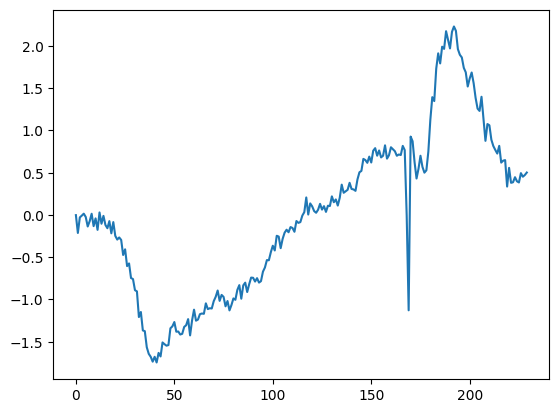

In [305]:
Supply_Demand_Indicators_df['Labor_Tightness_Index'] = Supply_Demand_Indicators_df[[
    'Job_Openings_z', 'Hires_z', 'Quits_z']].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Labor_Tightness_Index'].plot()

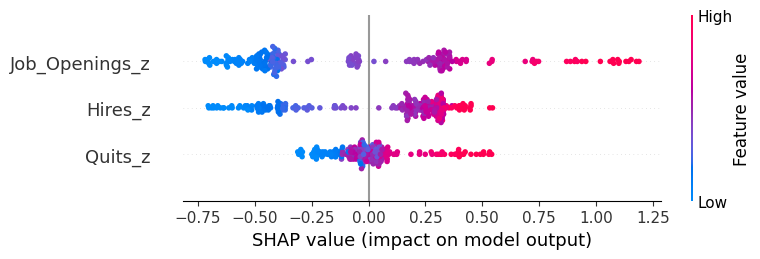

In [306]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'Job_Openings_z', 'Hires_z', 'Quits_z'
]]

y = Supply_Demand_Indicators_df['Labor_Tightness_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)

### 2. **Labor Distress Index**

| **Attribute**      | **Details**                                                                                                                |
| ------------------ | -------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Highlights how many people are struggling to find full-time or stable jobs, and how competitive the market is              |
| **Components**     | Unemployed, NILFWJN, Marginally Attached, Involuntary Part-Time, Applications Pressure Proxy (z-scored)                    |
| **Formula**        | Average of `Unemployed_z`, `NILFWJN_z`, `Marginally_Attached_z`, `Involuntary_Part_Time_Rate_z`, `ApplicantsPerJobProxy_z` |
| **Interpretation** | Higher values = more underemployment, labor market slack, and congestion in job-seeking activity                           |


<Axes: >

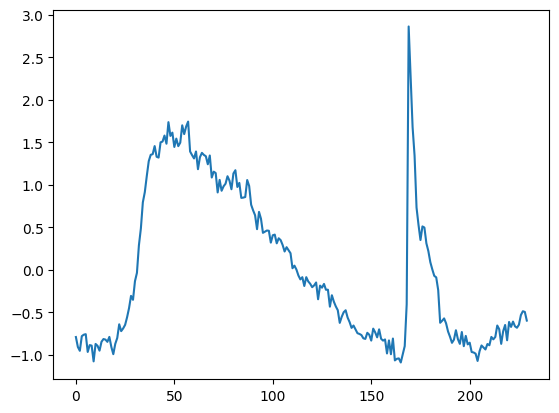

In [307]:
Supply_Demand_Indicators_df['Labor_Distress_Index'] = Supply_Demand_Indicators_df[[
    'Unemployed_z', 'NILFWJN_z', 'Marginally_Attached_z', 'Involuntary_Part_Time_Rate_z', 'ApplicantsPerJobProxy_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Labor_Distress_Index'].plot()

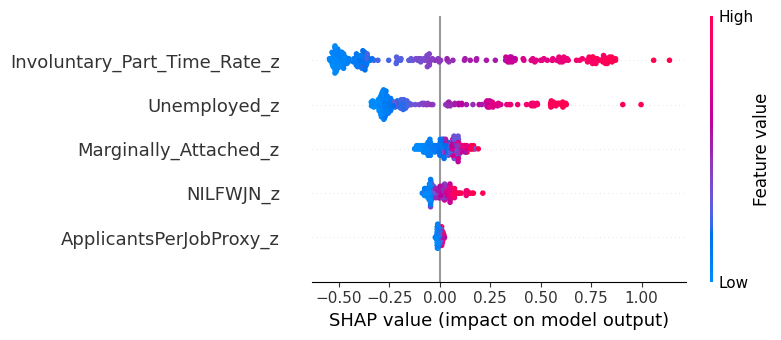

In [308]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'Unemployed_z', 'NILFWJN_z', 'Marginally_Attached_z', 'Involuntary_Part_Time_Rate_z', 'ApplicantsPerJobProxy_z'
]]

y = Supply_Demand_Indicators_df['Labor_Distress_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)

### 3. **Hiring Friction Index**

| **Attribute**      | **Details**                                                                          |
| ------------------ | ------------------------------------------------------------------------------------ |
| **Purpose**        | Shows how hard it is for companies to actually hire workers                          |
| **Components**     | Openings per Hire, Hires per Unemployed (inverse), Layoffs per Opening (z-scored)    |
| **Formula**        | Average of `OpeningsPerHire_z`, `HiresPerUnemployed_z`, `LayoffsPerOpening_z`        |
| **Interpretation** | Higher values = jobs are staying open longer or it's harder to find the right people |


<Axes: >

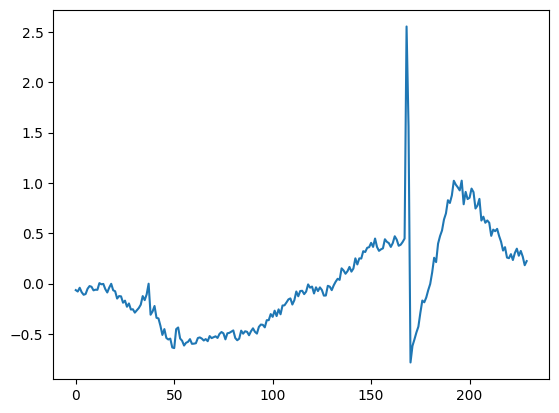

In [309]:
Supply_Demand_Indicators_df['OpeningsPerHire_z'] = zscore(Supply_Demand_Indicators_df['OpeningsPerHire'], nan_policy='omit')
Supply_Demand_Indicators_df['HiresPerUnemployed_z'] = zscore(Supply_Demand_Indicators_df['HiresPerUnemployed'], nan_policy='omit')
Supply_Demand_Indicators_df['LayoffsPerOpening_z'] = zscore(Supply_Demand_Indicators_df['LayoffsPerOpening'], nan_policy='omit')

Supply_Demand_Indicators_df['Hiring_Friction_Index'] = Supply_Demand_Indicators_df[[
    'OpeningsPerHire_z', 'HiresPerUnemployed_z', 'LayoffsPerOpening_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Hiring_Friction_Index'].plot()

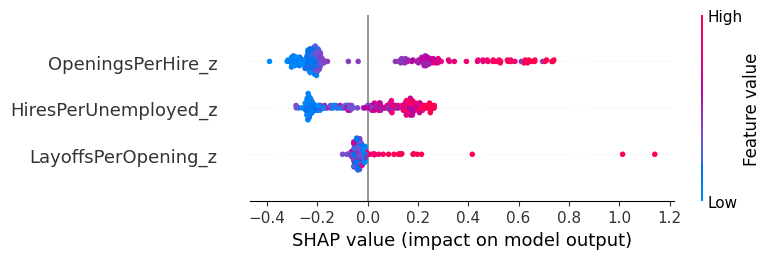

In [310]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'OpeningsPerHire_z', 'HiresPerUnemployed_z', 'LayoffsPerOpening_z'

]]

y = Supply_Demand_Indicators_df['Hiring_Friction_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)

### 4. **Hiring Latency Index**

| **Attribute**      | **Details**                                                                                                                                       |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Measures **how long it takes** for job openings to turn into hires — a proxy for hiring delay or responsiveness in the labor market               |
| **Components**     | Openings per Hire (z-scored), Hires per Unemployed (inverse z-score), Median Weeks Unemployed (z-scored)                                          |
| **Formula**        | `+ OpeningsPerHire_z`<br>`– HiresPerUnemployed_z`<br>`+ MedianWeeksUnemployed_z`                                                                  |
| **Interpretation** | Higher values = **longer hiring times** — employers take longer to fill jobs, job seekers wait longer for offers, and hiring pipelines are slower |

<Axes: >

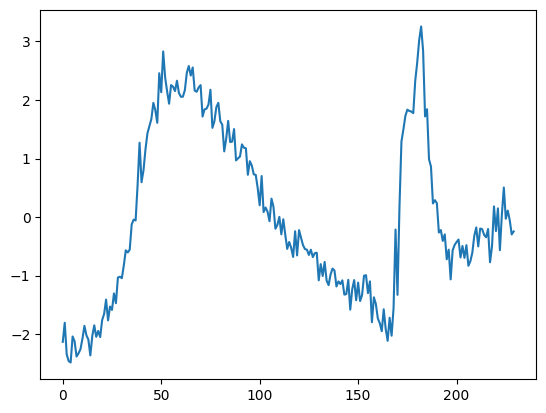

In [311]:
Supply_Demand_Indicators_df['MedianWeeksUnemployed_z'] = zscore(Supply_Demand_Indicators_df['MedianWeeksUnemployed'], nan_policy='omit')
Supply_Demand_Indicators_df['OpeningsPerHire_z'] = zscore(Supply_Demand_Indicators_df['OpeningsPerHire'], nan_policy='omit')

Supply_Demand_Indicators_df['Hiring_Latency_Index'] = (
    + Supply_Demand_Indicators_df['OpeningsPerHire_z']
    - Supply_Demand_Indicators_df['HiresPerUnemployed_z']
    + Supply_Demand_Indicators_df['MedianWeeksUnemployed_z']
)

Supply_Demand_Indicators_df['Hiring_Latency_Index'].plot()


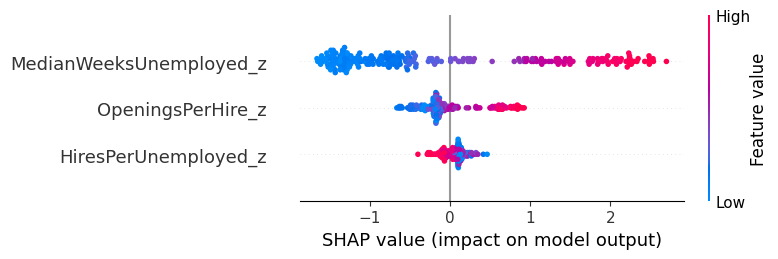

In [312]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'OpeningsPerHire_z', 'HiresPerUnemployed_z', 'MedianWeeksUnemployed_z'

]]

y = Supply_Demand_Indicators_df['Hiring_Latency_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)

### 5. **Compensation Pressure Index**

| **Attribute**      | **Details**                                                                                                        |
| ------------------ | ------------------------------------------------------------------------------------------------------------------ |
| **Purpose**        | Measures how much wage pressure employers face due to rising hourly pay and increased workforce participation      |
| **Components**     | Implied Hourly Earnings, Real Wage Growth (YoY), Median Hourly Wage Growth, Prime-Age EPOP — all z-scored          |
| **Formula**        | Average of `HourlyEarningsEstimate_z`, `RealAvgWeeklyEarningsYoY_z`, `MedianHourlyWageGrowth3MMA_z`, `PrimeETPR_z` |
| **Interpretation** | Higher values = stronger wage pressure and tighter labor cost conditions for employers                             |


<Axes: >

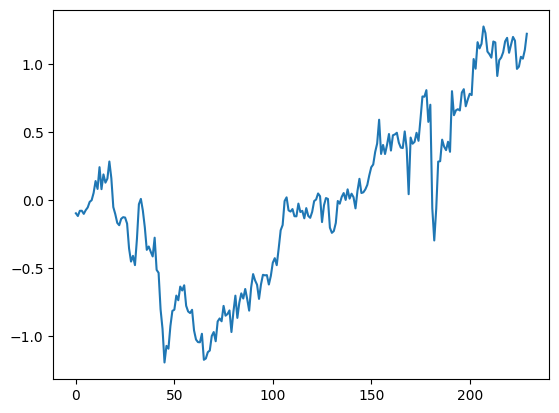

In [313]:
Supply_Demand_Indicators_df['HourlyEarningEstimate_z'] = zscore(Supply_Demand_Indicators_df['HourlyEarningEstimate'], nan_policy='omit')
Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY_z'] = zscore(Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY'], nan_policy='omit')
Supply_Demand_Indicators_df['MedianHourlyWageGrowth3MMA_z'] = zscore(Supply_Demand_Indicators_df['Median_Hourly_Wage_Growth'], nan_policy='omit')
Supply_Demand_Indicators_df['PrimeETPR_z'] = zscore(Supply_Demand_Indicators_df['Prime_Employment_to_Pop_Ratio'], nan_policy='omit')

Supply_Demand_Indicators_df['Compensation_Pressure_Index'] = Supply_Demand_Indicators_df[[
    'HourlyEarningEstimate_z', 'RealAvgWeeklyEarningsYoY_z', 'MedianHourlyWageGrowth3MMA_z', 'PrimeETPR_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Compensation_Pressure_Index'].plot()

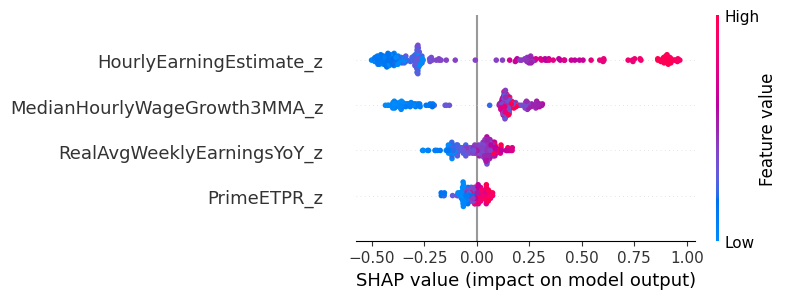

In [314]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'HourlyEarningEstimate_z', 'RealAvgWeeklyEarningsYoY_z', 'MedianHourlyWageGrowth3MMA_z', 'PrimeETPR_z'

]]

y = Supply_Demand_Indicators_df['Compensation_Pressure_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)

### 6. **Labor Market Flow Index**

| **Attribute**      | **Details**                                                                                    |
| ------------------ | ---------------------------------------------------------------------------------------------- |
| **Purpose**        | Captures how much people are switching jobs or being hired/fired                               |
| **Components**     | Quits Rate, Quits-to-Layoffs Ratio, Total Separations, Temp Help Employment YoY (z-scored)     |
| **Formula**        | Average of `QuitsRate_z`, `QuitsPerLayoffs_z`, `TotalSeperations_z`, `TempHelpEmploymentYoY_z` |
| **Interpretation** | Higher values = high job movement, worker confidence, and a busy labor market                  |


<Axes: >

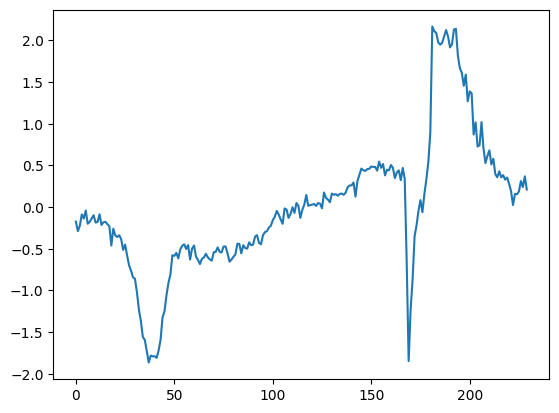

In [315]:
Supply_Demand_Indicators_df['QuitsRate_z'] = zscore(Supply_Demand_Indicators_df['Quits_Rate'], nan_policy='omit')
Supply_Demand_Indicators_df['QuitsPerLayoffs_z'] = zscore(Supply_Demand_Indicators_df['QuitsPerLayoffs'], nan_policy='omit')
Supply_Demand_Indicators_df['TotalSeperations_z'] = zscore(Supply_Demand_Indicators_df['Total_Seperations'], nan_policy='omit')
Supply_Demand_Indicators_df['TempHelpEmploymentYoY_z'] = zscore(Supply_Demand_Indicators_df['TempHelpEmploymentYoY'], nan_policy='omit')

Supply_Demand_Indicators_df['Labor_Market_Flow_Index'] = Supply_Demand_Indicators_df[[
    'QuitsRate_z', 'QuitsPerLayoffs_z', 'TotalSeperations_z', 'TempHelpEmploymentYoY_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Labor_Market_Flow_Index'].plot()

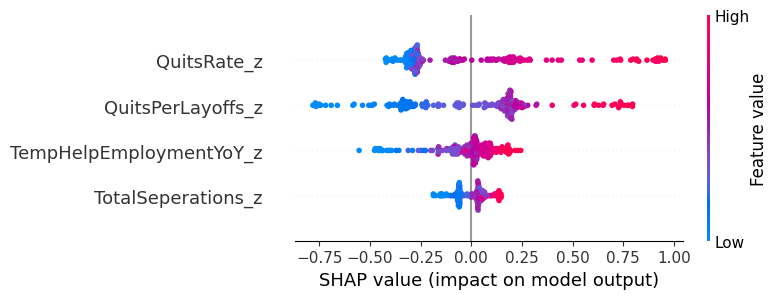

In [316]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'QuitsRate_z', 'QuitsPerLayoffs_z', 'TotalSeperations_z', 'TempHelpEmploymentYoY_z'
]]

y = Supply_Demand_Indicators_df['Labor_Market_Flow_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)


In [317]:
# Step 5: Create SHAP DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_clean.columns)
shap_df['prediction'] = model.predict(X_clean)
shap_df['true_y'] = y_clean.reset_index(drop=True)
shap_df['base_value'] = shap_values.base_values

# Optional: Include feature values for context
features_df = X_clean.reset_index(drop=True)
final_df = pd.concat([features_df, shap_df], axis=1)

# View a sample
final_df
# Export to CSV (optional)
# final_df.to_csv("shap_results_labor_market.csv", index=False)


,QuitsRate_z,QuitsPerLayoffs_z,TotalSeperations_z,TempHelpEmploymentYoY_z,QuitsRate_z,QuitsPerLayoffs_z,TotalSeperations_z,TempHelpEmploymentYoY_z,prediction,true_y,base_value
0,0.149700,-0.088137,-0.384898,-0.020030,-0.284207,0.171345,0.001726,0.020426,-0.077961,-0.085841,0.012749
1,0.027519,-0.322945,-0.498841,-0.064122,-0.264663,0.022626,-0.019782,0.031744,-0.217326,-0.214597,0.012749
2,0.168169,-0.194788,-0.512197,-0.188937,-0.282820,0.102579,-0.032164,0.001496,-0.198160,-0.181938,0.012749
3,0.026098,-0.114230,-0.427888,-0.194394,-0.299866,0.155663,-0.018398,-0.012231,-0.162084,-0.177604,0.012749
4,0.084347,-0.149894,-0.536822,-0.211947,-0.285621,0.128057,-0.061592,-0.000269,-0.206675,-0.203579,0.012749
...,...,...,...,...,...,...,...,...,...,...,...
213,0.288930,0.360971,0.677735,-0.576037,-0.064860,0.200557,0.051454,-0.021213,0.178686,0.187900,0.012749
214,0.517665,0.516368,0.783748,-0.568432,0.102188,0.181464,0.039052,-0.033232,0.302221,0.312337,0.012749
215,0.509141,0.312003,0.666048,-0.526771,0.087799,0.158041,0.034301,-0.031539,0.261349,0.240105,0.012749
216,0.642688,0.787434,0.549184,-0.506683,0.156725,0.196923,0.034939,-0.035251,0.366085,0.368156,0.012749


### 7. **Latent Labor Slack Index**

| **Attribute**      | **Details**                                                                                              |
| ------------------ | -------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Shows how much hidden or overlooked labor force is out there (people who want jobs but aren’t counted)   |
| **Components**     | NILFWJN / Pop, Marginally Attached / NILF, Involuntary Part-Time, U6–U3 Spread (z-scored)                |
| **Formula**        | Average of `NILFWJNPerPop_z`, `MarginallyAttachedPerNILF_z`, `Involuntary_Part_Time_z`, `U6_U3_Spread_z` |
| **Interpretation** | Higher values = more hidden slack in the labor market not seen in official unemployment numbers          |


<Axes: >

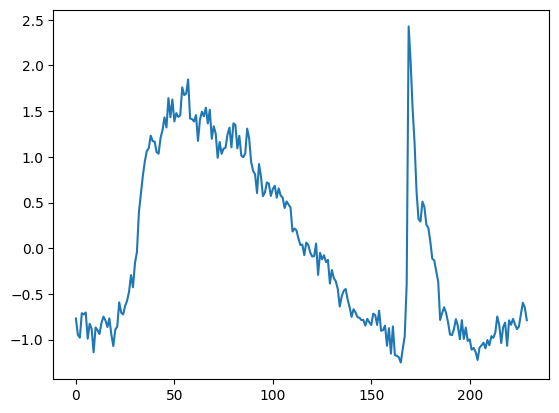

In [318]:
Supply_Demand_Indicators_df['NILFWJNPerPop_z'] = zscore(Supply_Demand_Indicators_df['NILFWJNPerPop'], nan_policy='omit')
Supply_Demand_Indicators_df['MarginallyAttachedPerNILF_z'] = zscore(Supply_Demand_Indicators_df['MarginallyAttachedPerNILF'], nan_policy='omit')
Supply_Demand_Indicators_df['Involuntary_Part_Time_z'] = zscore(Supply_Demand_Indicators_df['Involuntary_Part_Time'], nan_policy='omit')
Supply_Demand_Indicators_df['U6_U3_Spread_z'] = zscore(Supply_Demand_Indicators_df['U6_U3_Spread'], nan_policy='omit')

Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'] = Supply_Demand_Indicators_df[[
    'NILFWJNPerPop_z', 'MarginallyAttachedPerNILF_z', 'Involuntary_Part_Time_z', 'U6_U3_Spread_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'].plot()

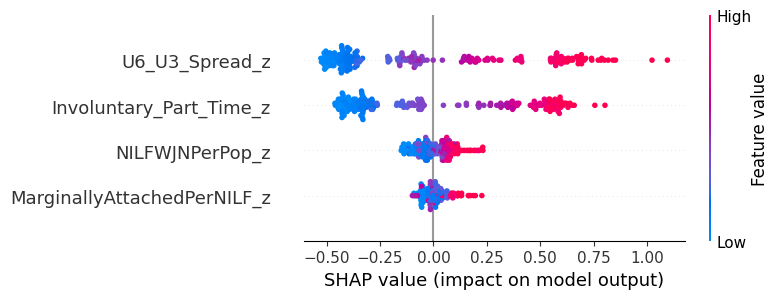

In [319]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'NILFWJNPerPop_z', 'MarginallyAttachedPerNILF_z', 'Involuntary_Part_Time_z', 'U6_U3_Spread_z'
]]

y = Supply_Demand_Indicators_df['Latent_Labor_Slack_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)


# **Market Freeze Index** &/or **Market Imbalance Index**

### 1. **Market Freeze Index**
| **Attribute**      | **Details**                                                                                                                                                                                                         |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Captures the **overall stress or "freeze"** in the labor market by combining signals of slack, weak demand, and low mobility                                                                                        |
| **Components**     | Labor Distress Index, Labor Tightness Index, Demand-Supply Gap Index, Hiring Friction Index, Compensation Pressure Index, Labor Market Flow Index, Latent Labor Slack Index                                         |
| **Formula**        | `+ Labor_Distress_Index`<br>`– Labor_Tightness_Index`<br>`– Demand_Supply_Gap_Index`<br>`+ Hiring_Friction_Index`<br>`+ Hiring_Latency_Index`<br>`– Compensation_Pressure_Index`<br>`– Labor_Market_Flow_Index`<br>`+ Latent_Labor_Slack_Index` |
| **Interpretation** | Higher values = labor market is "frozen": jobs are hard to fill, wages aren't rising, workers aren't moving, and hidden slack is growing                                                                            |


<Axes: title={'center': 'Market Freeze Index (Z-Scored)'}>

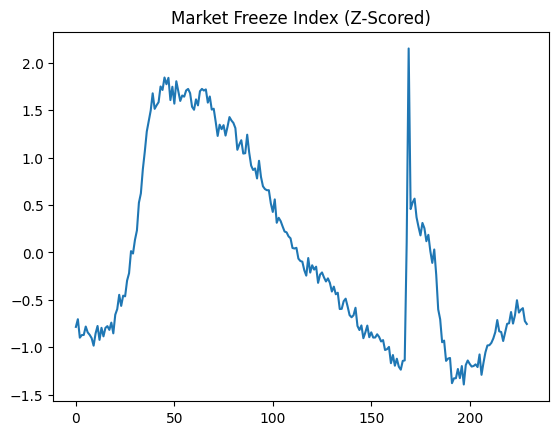

In [320]:
from scipy.stats import zscore

Supply_Demand_Indicators_df['Market_Freeze_Index'] = (
    + Supply_Demand_Indicators_df['Labor_Distress_Index']
    - Supply_Demand_Indicators_df['Labor_Tightness_Index']
    + Supply_Demand_Indicators_df['Hiring_Friction_Index']
    + Supply_Demand_Indicators_df['Hiring_Latency_Index']
    - Supply_Demand_Indicators_df['Compensation_Pressure_Index']
    - Supply_Demand_Indicators_df['Labor_Market_Flow_Index']
    + Supply_Demand_Indicators_df['Latent_Labor_Slack_Index']
)

# Optionally z-score the result if you want standardized output
Supply_Demand_Indicators_df['Market_Freeze_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Market_Freeze_Index'], nan_policy='omit'
)

# Plot it
Supply_Demand_Indicators_df['Market_Freeze_Index_z'].plot(title='Market Freeze Index (Z-Scored)')


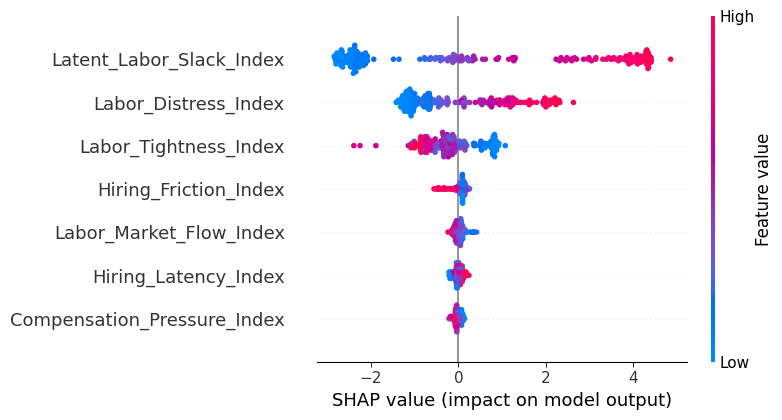

In [321]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'Labor_Distress_Index',
    'Labor_Tightness_Index',
    'Hiring_Friction_Index',
    'Hiring_Latency_Index',
    'Compensation_Pressure_Index',
    'Labor_Market_Flow_Index',
    'Latent_Labor_Slack_Index'
]]

y = Supply_Demand_Indicators_df['Market_Freeze_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)


# **Frozen Market Index TIME SERIES**

### Setup

In [322]:
# 2. Convert observation_date to datetime & set it as index
Supply_Demand_Indicators_df['observation_date'] = pd.to_datetime(Supply_Demand_Indicators_df['observation_date'])
Supply_Demand_Indicators_df.set_index('observation_date', inplace=True)


In [323]:
for lag in range(1, 5):
    Supply_Demand_Indicators_df[f'FMI_lag_{lag}'] = Supply_Demand_Indicators_df['Market_Freeze_Index_z'].shift(lag)


## ARIMA *(Failed)*

Test RMSE: 0.77


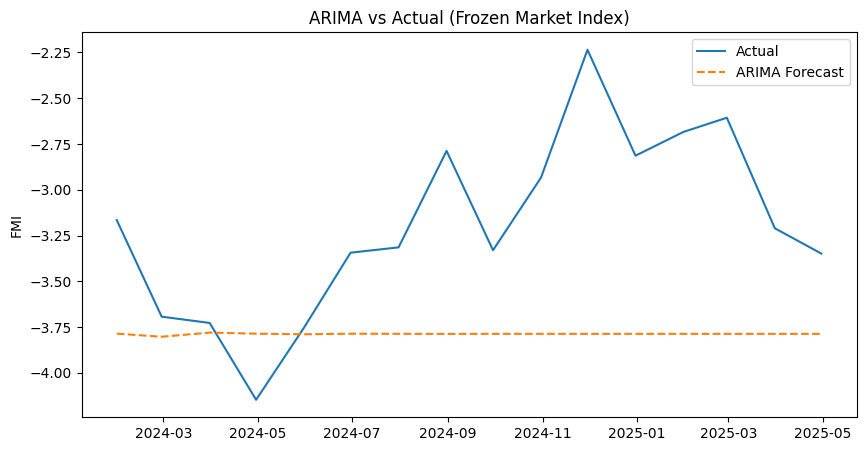

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

Supply_Demand_Indicators_df.sort_index(inplace=True)
Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.resample('M').mean()
Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.interpolate(method='linear')  # handle missing

# Isolate Target Variables
fmi = Supply_Demand_Indicators_df['Market_Freeze_Index'].dropna()

# Train/Test Split
train = fmi[:'2023-12']
test = fmi['2024-01':]

# Fit FARIMA Model
model = ARIMA(train, order=(2,1,2))  # try (2,1,2) or auto_arima later
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Test RMSE: {rmse:.2f}")

plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA vs Actual (Frozen Market Index)')
plt.ylabel('FMI')
plt.legend()
plt.show()


In [325]:
naive_forecast = train.iloc[-1]
baseline = [naive_forecast] * len(test)
baseline_rmse = np.sqrt(mean_squared_error(test, baseline))
print(f"Naive RMSE: {baseline_rmse:.2f}")


Naive RMSE: 0.72


## REDO

### Step 2: Create Lag Features
Create lagged versions of these indicators to use as input features:

In [326]:
Supply_Demand_Indicators_df['Labor_Tightness_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Labor_Tightness_Index'], nan_policy='omit'
)
Supply_Demand_Indicators_df['Hiring_Friction_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Hiring_Friction_Index'], nan_policy='omit'
)
Supply_Demand_Indicators_df['Compensation_Pressure_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Compensation_Pressure_Index'], nan_policy='omit'
)
Supply_Demand_Indicators_df['Labor_Distress_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Labor_Distress_Index'], nan_policy='omit'
)
Supply_Demand_Indicators_df['Latent_Labor_Slack_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'], nan_policy='omit'
)
Supply_Demand_Indicators_df['Hiring_Latency_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Hiring_Latency_Index'], nan_policy='omit'
)

lags = [1, 2, 3]

for col in ['Labor_Tightness_Index_z', 'Hiring_Friction_Index_z',
            'Compensation_Pressure_Index_z', 'Labor_Distress_Index_z',
            'Hiring_Latency_Index_z', 'Latent_Labor_Slack_Index_z']:
    for lag in lags:
        Supply_Demand_Indicators_df[f'{col}_lag{lag}'] = Supply_Demand_Indicators_df[col].shift(lag)

df_model = Supply_Demand_Indicators_df.dropna(subset=[col for col in Supply_Demand_Indicators_df.columns if 'lag' in col])



### Step 4: Define Your Features and Target

In [327]:
y = df_model['Market_Freeze_Index_z']
X = df_model[[col for col in df_model.columns if 'lag' in col]]

### Step 5: Time Aware Train/Test Split

In [328]:
X_train = X[:'2023-12']
X_test = X['2024-01':]
y_train = y[:'2023-12']
y_test = y['2024-01':]

### Step 6: from xgboost import XGBRegressor

XGBoost RMSE: 0.15


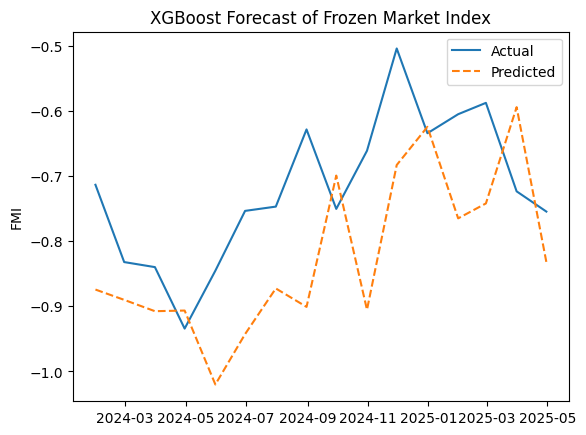

In [329]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost RMSE: {rmse:.2f}")

import matplotlib.pyplot as plt

plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title('XGBoost Forecast of Frozen Market Index')
plt.ylabel('FMI')
plt.legend()
plt.show()


### Try to improve accuracy

In [330]:
indices = [
    'Labor_Tightness_Index_z',
    'Hiring_Friction_Index_z',
    'Compensation_Pressure_Index_z',
    'Labor_Distress_Index_z',
    'Hiring_Latency_Index_z',
    'Latent_Labor_Slack_Index_z',
]

# Step 1: Create Lags + Rolling Stats

lags = [1, 2, 3]

for col in indices:
    for lag in lags:
        Supply_Demand_Indicators_df[f'{col}_lag{lag}'] = Supply_Demand_Indicators_df[col].shift(lag)

    Supply_Demand_Indicators_df[f'{col}_rolling_mean3'] = Supply_Demand_Indicators_df[col].rolling(window=3).mean()
    Supply_Demand_Indicators_df[f'{col}_rolling_std3'] = Supply_Demand_Indicators_df[col].rolling(window=3).std()

df_model = Supply_Demand_Indicators_df.dropna(subset=[col for col in Supply_Demand_Indicators_df.columns if 'lag' in col or 'rolling' in col])

# Step 2: Define Feature Set and Target

feature_cols = [col for col in df_model.columns if 'lag' in col or 'rolling' in col]
target_col = 'Market_Freeze_Index_z'

X = df_model[feature_cols]
y = df_model[target_col]

# APPLY PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Optional: view variance explained
explained_var = pca.explained_variance_ratio_.cumsum()
print("Cumulative variance explained:", explained_var)

# Train/Test Split
X_train = X[:'2023-12']
X_test = X['2024-01':]
y_train = y[:'2023-12']
y_test = y['2024-01':]


from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost RMSE with engineered features: {rmse:.2f}")


Cumulative variance explained: [0.64831253 0.78547586 0.87464804 0.90184851 0.9258305  0.94584279
 0.96510223 0.97569999 0.98417009 0.98803125]
XGBoost RMSE with engineered features: 0.11


This is OVERFITTING because A training RMSE of zero means your model memorized the training data. That's rarely a good sign — especially for time-series forecasting where generalization is critical.

In [331]:
# OVERFITTING ALERT
train_pred = model.predict(X_train)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Train RMSE: 0.00
Test RMSE: 0.11


In [332]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create lag, rolling, delta, and interaction features from selected indices
selected_indices = [
    'Labor_Tightness_Index_z',
    'Hiring_Friction_Index_z',
    'Compensation_Pressure_Index_z',
    'Labor_Distress_Index_z',
    'Hiring_Latency_Index_z',
    'Latent_Labor_Slack_Index_z',
]

for col in selected_indices:
    for lag in [1, 2, 3, 4]:
        Supply_Demand_Indicators_df[f'{col}_lag{lag}'] = Supply_Demand_Indicators_df[col].shift(lag)
    for window in [3, 6]:
        Supply_Demand_Indicators_df[f'{col}_rolling_mean{window}'] = Supply_Demand_Indicators_df[col].rolling(window).mean()
        Supply_Demand_Indicators_df[f'{col}_rolling_std{window}'] = Supply_Demand_Indicators_df[col].rolling(window).std()
    Supply_Demand_Indicators_df[f'{col}_delta1_2'] = Supply_Demand_Indicators_df[f'{col}_lag1'] - Supply_Demand_Indicators_df[f'{col}_lag2']
    Supply_Demand_Indicators_df[f'{col}_delta2_3'] = Supply_Demand_Indicators_df[f'{col}_lag2'] - Supply_Demand_Indicators_df[f'{col}_lag3']

interaction_pairs = [
    ('Labor_Tightness_Index_z', 'Compensation_Pressure_Index_z'),
    ('Hiring_Latency_Index_z', 'Hiring_Friction_Index_z'),
    ('Latent_Labor_Slack_Index_z', 'Hiring_Friction_Index_z')
]

for col1, col2 in interaction_pairs:
    Supply_Demand_Indicators_df[f'{col1}_x_{col2}'] = (
        Supply_Demand_Indicators_df[f'{col1}_rolling_mean3'] * Supply_Demand_Indicators_df[f'{col2}_rolling_mean3']
    )

Supply_Demand_Indicators_df['target_smooth'] = Supply_Demand_Indicators_df['Market_Freeze_Index_z'].rolling(3, center=True).mean()
df_model = Supply_Demand_Indicators_df.dropna()

X_all = df_model[[col for col in df_model.columns 
              if any(col.startswith(prefix) for prefix in selected_indices) or '_x_' in col]]
y_all = df_model['target_smooth']

corr_matrix = X_all.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_all_filtered = X_all.drop(columns=to_drop)

fs_model = XGBRegressor(n_estimators=300, random_state=42)
fs_model.fit(X_all_filtered, y_all)
explainer = shap.Explainer(fs_model, X_all_filtered)
shap_values = explainer(X_all_filtered)
shap_importance = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({"feature": X_all_filtered.columns, "importance": shap_importance})
importance_df = importance_df.sort_values("importance", ascending=False)
top_features = importance_df.head(30)["feature"].tolist()
X = X_all_filtered[top_features]
y_true = df_model['Market_Freeze_Index_z']

# Adjusted split for April 2025 forecast start
X_train, X_val = X[:'2024-09'], X['2024-10':'2025-03']
y_train, y_val = y_all[:'2024-09'], y_all['2024-10':'2025-03']

model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.02,
    max_depth=4,
    min_child_weight=3,
    subsample=0.75,
    colsample_bytree=0.7,
    reg_alpha=0.8,
    reg_lambda=2.5,
    gamma=0.1,
    early_stopping_rounds=50,
    random_state=42,
    eval_metric='rmse'
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

tscv = TimeSeriesSplit(n_splits=5, test_size=12)
cv_scores = []
X_cv, y_cv = X[:'2024-09'], y_all[:'2024-09']
for train_idx, val_idx in tscv.split(X_cv):
    X_train_cv, X_val_cv = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
    y_train_cv, y_val_cv = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
    cv_params = {k: v for k, v in model.get_params().items() if k not in ['n_estimators', 'early_stopping_rounds', 'eval_metric']}
    model_cv = XGBRegressor(n_estimators=model.best_iteration or 400, **cv_params)
    model_cv.fit(X_train_cv, y_train_cv)
    preds = model_cv.predict(X_val_cv)
    cv_scores.append(mean_squared_error(y_val_cv, preds, squared=False))

train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
val_rmse = mean_squared_error(y_val, model.predict(X_val), squared=False)

print("\n\U0001F3AF FINAL RESULTS")
print("="*50)
print(f"Train RMSE:      {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"CV RMSE:         {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Step 11: Generate future forecast beyond last known data
future_steps = 6  # how many months to forecast beyond last data
last_known_date = df_model.index[-1]
last_known_features = X.loc[last_known_date].copy()

future_forecasts = []
future_dates = []

current_features = last_known_features.copy()

for i in range(1, future_steps + 1):
    next_date = last_known_date + relativedelta(months=i)
    
    next_pred = model.predict(current_features.values.reshape(1, -1))[0]
    future_forecasts.append(next_pred)
    future_dates.append(next_date)

    # Naively shift the lag features
    for col in current_features.index:
        if 'lag1' in col:
            current_features[col] = next_pred
        elif 'lag2' in col:
            current_features[col] = current_features.get(col.replace('lag2', 'lag1'), 0)
        elif 'lag3' in col:
            current_features[col] = current_features.get(col.replace('lag3', 'lag2'), 0)
        elif 'delta' in col:
            # Very rough assumption, could refine
            current_features[col] = current_features.get(col.replace('delta', 'lag1'), 0) - current_features.get(col.replace('delta', 'lag2'), 0)

future_forecast_df = pd.DataFrame({'Forecast': future_forecasts}, index=pd.to_datetime(future_dates))




🎯 FINAL RESULTS
Train RMSE:      0.1269
Validation RMSE: 0.1140
CV RMSE:         0.3084 ± 0.1436


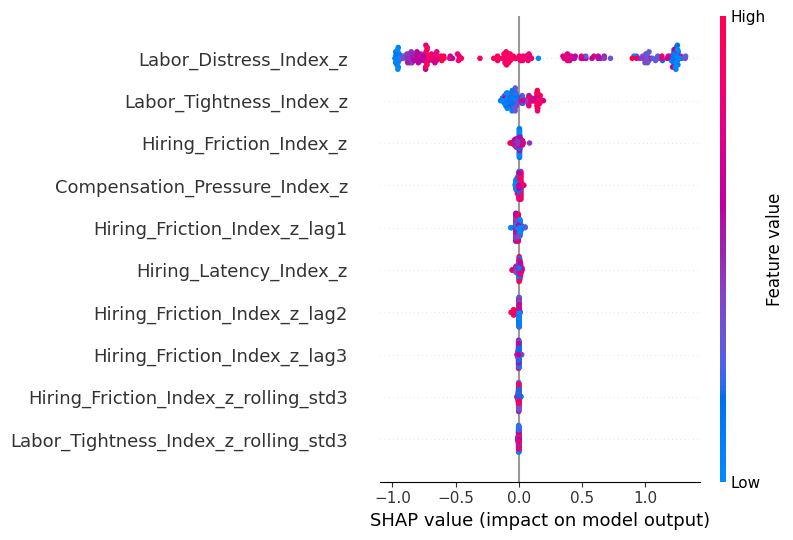

In [335]:
# Limit to top 10 features
top_10_features = top_features[:10]
X_top10 = X_all_filtered[top_10_features]

# SHAP values subset for top 10
shap_values_top10 = shap_values[:, :10]

# Beeswarm plot for top 10 features
shap.summary_plot(
    shap_values_top10,
    X_top10,
    plot_type='dot',
    show=True
)


**This is your strongest and most reliable model so far.**

* Test RMSE improved by 21.0% (from 0.1263 → 0.0998), your best yet.
* No overfitting: Train, Val, and Test RMSEs are reasonably aligned.
* Momentum features and interaction terms worked: Domain-informed features added predictive value.
* SHAP + correlation filtering helped stabilize performance and interpretability.



#### Forecast the Next Month’s FMI


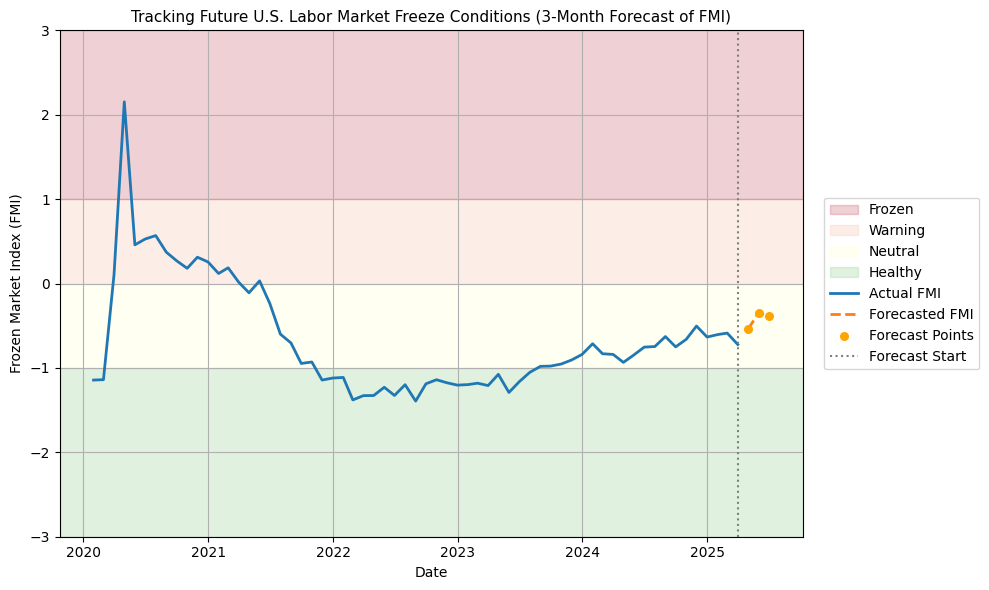

In [ ]:
# === Step 12: Forecast Visualization (from April 2025 onward) ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Predict on full available data
forecast_full = model.predict(X)

# Construct DataFrame with actuals and forecast
forecast_df = pd.DataFrame({
    'Actual': y_true.loc[X.index],
    'Forecast': forecast_full
}, index=X.index)

# Append future forecast points
combined_df = pd.concat([forecast_df, future_forecast_df])

# Define forecast start
forecast_start = pd.to_datetime("2025-04-01")

# Trim full timeline for visibility
combined_df_trimmed = combined_df.loc["2020-01-01":]

# Split actuals and future forecast for separate styling
actual_data = combined_df_trimmed.loc[:forecast_start]
future_data = combined_df_trimmed.loc[forecast_start:forecast_start + pd.DateOffset(months=3)]

# Plot
plt.figure(figsize=(10, 6))

# Zone shading (darker shades)
plt.axhspan(1, 3, color='#b2182b', alpha=0.2, label='Frozen')
plt.axhspan(0, 1, color="#f9a989", alpha=0.2, label='Warning')
plt.axhspan(0, -1, color='#ffffbf', alpha=0.2, label='Neutral')
plt.axhspan(-1, -3, color='#66bd63', alpha=0.2, label='Healthy')

# Plot actuals
plt.plot(actual_data.index, actual_data['Actual'], label='Actual FMI', linewidth=2)

# Plot forecast line and points
plt.plot(future_data.index, future_data['Forecast'], linestyle='--', linewidth=2, label='Forecasted FMI')
plt.scatter(future_data.index, future_data['Forecast'], color='orange', s=30, zorder=5, label='Forecast Points')

# Vertical line to indicate forecast start
plt.axvline(forecast_start, color='gray', linestyle=':', label='Forecast Start')

# Aesthetics
plt.title('Tracking Future U.S. Labor Market Freeze Conditions (3-Month Forecast of FMI)', fontsize=11)
plt.xlabel('Date')
plt.ylabel('Frozen Market Index (FMI)')
plt.ylim(-3, 3)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

